# **HyperParameter Tuning for CNN**


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/My Drive/P2_TimeForecast/P2_CodeBase"

# install import-ipynb for importing helper modules
!pip install import-ipynb
import import_ipynb

# importing helper functions for data preprocessing and model visualization
import plotlib_helper as gplot
import datapreprocess_helper as dataprep

/content/drive/My Drive/P2_TimeForecast/P2_CodeBase
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=3dca7e082ac4f3f31e87b3894aa84fe87aac938152a3d7a22c112ad44b5adab1
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
importing Jupyter notebook from plotlib_helper.ipynb
importing Jupyter notebook from datapreprocess_helper.ipynb


Define data and dnn folder paths

In [4]:
data_path = "/content/drive/My Drive/P2_TimeForecast/P2_CodeBase/data/"
dnn_path = "/content/drive/My Drive/P2_TimeForecast/P2_CodeBase/dnn/"

## Load Preprocessed data

In [5]:
import pandas as pd
import io
import os
import requests
import numpy as np
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


filepath = os.path.join(data_path, "P2_Preprocessed_CNN_LSTM.csv")
df = pd.read_csv(filepath, na_values=['NA','?','-'])

print(df.dtypes , df.shape)
print()
print(df[0:5])
print()
print(df.isnull().sum())

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
Output    float64
dtype: object (4392, 6)

       Open      High       Low     Close    Volume    Output
0 -0.894209 -0.885022 -0.892306 -0.884364  1.104812  4.125000
1 -0.883762 -0.886056 -0.885975 -0.888021 -0.497301  4.015625
2 -0.887941 -0.889159 -0.887558 -0.888543 -0.892217  4.000000
3 -0.887941 -0.890194 -0.891251 -0.893768 -0.000263  3.843750
4 -0.896820 -0.898986 -0.906551 -0.908920  3.729366  3.390625

Open      0
High      0
Low       0
Close     0
Volume    0
Output    0
dtype: int64


## Spliting dataframe into features and target

In [6]:
y = df['Output'].copy() # y is copy of close column
x = df.drop(columns=['Output'], axis= 1, inplace=False)

x = x.to_numpy(dtype="float32");
y = y.to_numpy(dtype="float32");

print(x.shape, y.shape)
print(x[0:5])
print(y[0:5])

(4392, 5) (4392,)
[[-8.9420879e-01 -8.8502169e-01 -8.9230639e-01 -8.8436353e-01
   1.1048120e+00]
 [-8.8376242e-01 -8.8605607e-01 -8.8597530e-01 -8.8802087e-01
  -4.9730068e-01]
 [-8.8794094e-01 -8.8915926e-01 -8.8755810e-01 -8.8854337e-01
  -8.9221716e-01]
 [-8.8794094e-01 -8.9019364e-01 -8.9125121e-01 -8.9376807e-01
  -2.6340524e-04]
 [-8.9682037e-01 -8.9898598e-01 -9.0655136e-01 -9.0891981e-01
   3.7293661e+00]]
[4.125    4.015625 4.       3.84375  3.390625]


## Converting array into 4D array for CNN using to_sequence()

In [7]:
import numpy as np

def to_sequences(seq_size, input, target):
    x = []
    y = []

    for i in range(len(target)-seq_size-1):
        window = input[i:(i+seq_size)]
        after_window = target[i+seq_size]
        window = [x for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [8]:
# each record is converted into 7X5 array
SEQ_SIZE = 7
x,y = to_sequences(SEQ_SIZE, x, y)
print(x.shape , y.shape)
print(x[0:2])
print(y[0:2])

(4384, 7, 5) (4384,)
[[[-8.9420879e-01 -8.8502169e-01 -8.9230639e-01 -8.8436353e-01
    1.1048120e+00]
  [-8.8376242e-01 -8.8605607e-01 -8.8597530e-01 -8.8802087e-01
   -4.9730068e-01]
  [-8.8794094e-01 -8.8915926e-01 -8.8755810e-01 -8.8854337e-01
   -8.9221716e-01]
  [-8.8794094e-01 -8.9019364e-01 -8.9125121e-01 -8.9376807e-01
   -2.6340524e-04]
  [-8.9682037e-01 -8.9898598e-01 -9.0655136e-01 -9.0891981e-01
    3.7293661e+00]
  [-9.0465510e-01 -9.0002036e-01 -9.0496856e-01 -9.0735239e-01
    5.9217567e+00]
  [-9.0361047e-01 -9.0415794e-01 -9.1657561e-01 -9.0526253e-01
    6.9392648e+00]]

 [[-8.8376242e-01 -8.8605607e-01 -8.8597530e-01 -8.8802087e-01
   -4.9730068e-01]
  [-8.8794094e-01 -8.8915926e-01 -8.8755810e-01 -8.8854337e-01
   -8.9221716e-01]
  [-8.8794094e-01 -8.9019364e-01 -8.9125121e-01 -8.9376807e-01
   -2.6340524e-04]
  [-8.9682037e-01 -8.9898598e-01 -9.0655136e-01 -9.0891981e-01
    3.7293661e+00]
  [-9.0465510e-01 -9.0002036e-01 -9.0496856e-01 -9.0735239e-01
    5.921756

## Reshaping array - adding 4th dimension 

In [9]:
# reshaping the array, adding 4th dimension
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
print(x.shape , y.shape)

(4384, 7, 5, 1) (4384,)


## Splitting array into train & test set (70-30)

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=120)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print()
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))


x_train shape: (3068, 7, 5, 1)
x_test shape: (1316, 7, 5, 1)
y_train shape: (3068,)
y_test shape: (1316,)

Training samples: 3068
Test samples: 1316


## Training, Fitting and Model Evaluation for CNN model

#### **LAYERS AND NEURON COUNT**

##### **Case 1 : Single Conv layer**

In [ ]:
layers={'Conv': 64 ,'Dense': 128}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': 64, 'Dense': 128}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_layers_v1.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(64, kernel_size=(3, 3), padding='valid',input_shape = input_shape, activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.2))

  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 00012: early stopping
Epoch 00015: early stopping
Epoch 00012: early stopping
Elapsed time: 11.64893388748169
Best Model loaded ....


###### Case 1: Model Performance Evaluation

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 5, 3, 64)          640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 1, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 1, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

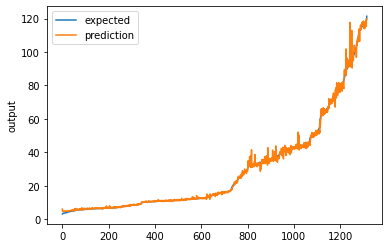

In [ ]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"Convolutional Neural Networks - Single Conv Layer", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### **Case 2 : Multiple layers 2 Conv**

In [ ]:
layers={'Conv': [32, 64] ,'Dense': 128}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': [32, 64], 'Dense': 128}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_layers_v2.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid",activation='relu', input_shape=input_shape)) 
  model.add(Conv2D(64, (2, 2), padding="valid",activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25)) 

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))


  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 00013: early stopping
Epoch 00009: early stopping
Epoch 00013: early stopping
Elapsed time: 12.529295921325684
Best Model loaded ....


###### Case 2: Model Performance Evaluation

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 5, 3, 32)          320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 1, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2, 1, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)              

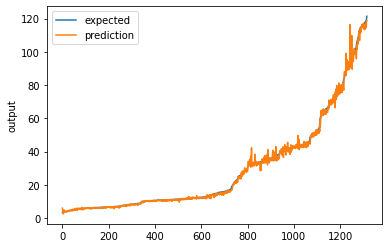

In [ ]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"Convolutional Neural Networks - Multiple Conv Layer", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### **Case 3 : Multiple layers- 2 Conv and Increased Neuron Count**

In [ ]:
layers={'Conv': [256, 128] ,'Dense': 128}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': [256, 128], 'Dense': 128}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_layers_v3.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding="valid",activation='relu', input_shape=input_shape)) 
  model.add(Dropout(0.10))

  model.add(Conv2D(128, (2, 2), padding="valid",activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25)) 

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))


  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 00009: early stopping
Epoch 00009: early stopping
Epoch 00006: early stopping
Elapsed time: 52.88858103752136
Best Model loaded ....


###### Case 3: Model Performance Evaluation

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 5, 3, 256)         2560      
_________________________________________________________________
dropout_36 (Dropout)         (None, 5, 3, 256)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 4, 2, 128)         131200    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 2, 1, 128)         0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 2, 1, 128)         0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)             

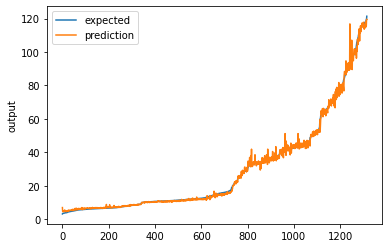

In [ ]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"Multiple layers- 2 Conv and Increased Neuron Count", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### **Case 4 : Multiple layers -3 Conv layers**

In [ ]:
layers={'Conv': [32, 64 , 128] ,'Dense': 128}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': [32, 64, 128], 'Dense': 128}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_layers_v4.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid",activation='relu', input_shape=input_shape)) 
  
  model.add(Conv2D(64, (2, 2), padding="valid",activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (2, 2), padding="same",activation='relu'))
  model.add(Dropout(0.20))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  # output layer
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 00011: early stopping
Epoch 00013: early stopping
Epoch 00006: early stopping
Elapsed time: 19.474169492721558
Best Model loaded ....


###### Case 4: Model Performance Evaluation

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 5, 3, 32)          320       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 4, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 2, 1, 64)          0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 2, 1, 64)          0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 2, 1, 128)         32896     
_________________________________________________________________
dropout_55 (Dropout)         (None, 2, 1, 128)         0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 256)             

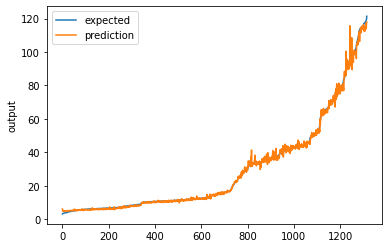

In [ ]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"Case 3 : Multiple layers -3 Conv layers", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### **Case 5 : Kernel Count- 128, 64, 32**

In [12]:
layers={'Conv': [128, 64, 32] ,'Dense': 128}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': [128, 64, 32], 'Dense': 128}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_layers_v5.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding="valid",activation='relu', input_shape=input_shape)) 
  
  model.add(Conv2D(64, (2, 2), padding="valid",activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(32, (2, 2), padding="same",activation='relu'))
  #model.add(Dropout(0.20))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  # output layer
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 00012: early stopping
Epoch 00008: early stopping
Epoch 00008: early stopping
Elapsed time: 15.618116855621338
Best Model loaded ....


###### Case 4: Model Performance Evaluation

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 5, 3, 128)         1280      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 2, 64)          32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 1, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 1, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 1, 32)          8224      
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

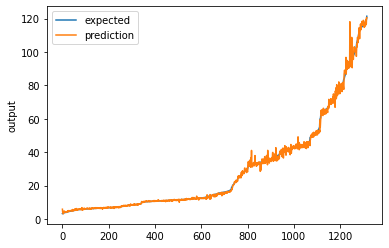

In [14]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"CNN  Kernel Count - 128, 64, 32", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### **Case 6 : Kernel Count- 512, 128, 64**

In [15]:
layers={'Conv': [512, 128, 64] ,'Dense': 128}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': [512, 128, 64], 'Dense': 128}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_layers_v6.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding="valid",activation='relu', input_shape=input_shape)) 
  
  model.add(Conv2D(128, (2, 2), padding="valid",activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (2, 2), padding="same",activation='relu'))
  model.add(Dropout(0.10))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  # output layer
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 00005: early stopping
Epoch 00006: early stopping
Epoch 00010: early stopping
Elapsed time: 72.60158658027649
Best Model loaded ....


###### Case 6: Model Performance Evaluation

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 5, 3, 512)         5120      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4, 2, 128)         262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 1, 128)         0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 2, 1, 128)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 2, 1, 64)          32832     
_________________________________________________________________
dropout_13 (Dropout)         (None, 2, 1, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)              

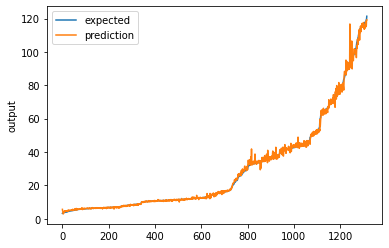

In [17]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"CNN  Kernel Count - 512, 128, 64", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### **Case 7 : Kernel Count- 128, 50, 30**

In [21]:
layers={'Conv': [1024, 512, 128] ,'Dense': 128}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': [1024, 512, 128], 'Dense': 128}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_layers_v7.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(1024, kernel_size=(3, 3), strides=(1, 1), padding="valid",activation='relu', input_shape=input_shape)) 
  
  model.add(Conv2D(512, (2, 2), padding="valid",activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (2, 2), padding="same",activation='relu'))
  model.add(Dropout(0.20))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  # output layer
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 00007: early stopping
Epoch 00006: early stopping
Epoch 00007: early stopping
Elapsed time: 431.40724062919617
Best Model loaded ....


###### Case 7: Model Performance Evaluation

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 5, 3, 1024)        10240     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 4, 2, 512)         2097664   
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 2, 1, 512)         0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 2, 1, 512)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 2, 1, 128)         262272    
_________________________________________________________________
dropout_31 (Dropout)         (None, 2, 1, 128)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 256)             

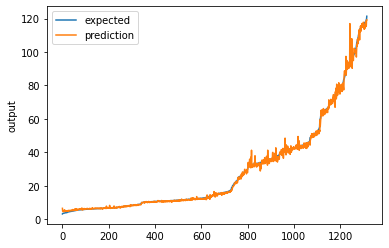

In [23]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"CNN  Kernel Count - 1024, 512, 128", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

#### **OPTIMIZER AND ACTIVATION FUNCTION**

##### **Case 1 : Adam - ReLU**

In [ ]:
layers={'Conv': [32, 64 , 128] ,'Dense': 128}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': [32, 64, 128], 'Dense': 128}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_OptAct_v1.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid",activation='relu', input_shape=input_shape)) 
  
  model.add(Conv2D(64, (2, 2), padding="valid",activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (2, 2), padding="same",activation='relu'))
  model.add(Dropout(0.20))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  # output layer
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

###### Case 1: Model Performance Evaluation

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 5, 3, 32)          320       
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 4, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 2, 1, 64)          0         
_________________________________________________________________
dropout_111 (Dropout)        (None, 2, 1, 64)          0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 2, 1, 128)         32896     
_________________________________________________________________
dropout_112 (Dropout)        (None, 2, 1, 128)         0         
_________________________________________________________________
flatten_56 (Flatten)         (None, 256)             

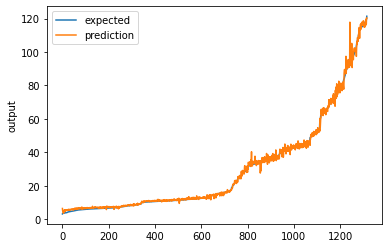

In [ ]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"CNN - Adam-ReLU", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### **Case 2 : Adam - Sigmoid**

In [ ]:
layers={'Conv': [32, 64 , 128] ,'Dense': 128}
activation=["sigmoid"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': [32, 64, 128], 'Dense': 128}, 'activation': ['sigmoid'], 'optimizer': ['adam']}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_OptAct_v2.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid",activation='sigmoid', input_shape=input_shape)) 
  
  model.add(Conv2D(64, (2, 2), padding="valid",activation='sigmoid'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (2, 2), padding="same",activation='sigmoid'))
  model.add(Dropout(0.20))

  model.add(Flatten())
  model.add(Dense(128, activation='sigmoid'))
  model.add(Dropout(0.5))
  # output layer
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 00045: early stopping
Epoch 00042: early stopping
Epoch 00043: early stopping
Elapsed time: 59.568785190582275
Best Model loaded ....


###### Case 2: Model Performance Evaluation

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 5, 3, 32)          320       
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 4, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 2, 1, 64)          0         
_________________________________________________________________
dropout_120 (Dropout)        (None, 2, 1, 64)          0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 2, 1, 128)         32896     
_________________________________________________________________
dropout_121 (Dropout)        (None, 2, 1, 128)         0         
_________________________________________________________________
flatten_59 (Flatten)         (None, 256)             

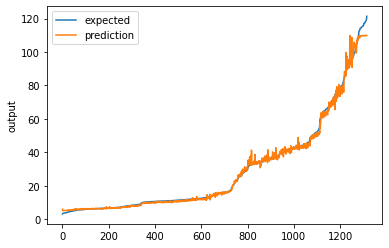

In [ ]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"CNN - Adam-Sigmoid", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### **Case 3 : Adam - Tanh**

In [ ]:
layers={'Conv': [32, 64 , 128] ,'Dense': 128}
activation=["tanh"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': [32, 64, 128], 'Dense': 128}, 'activation': ['tanh'], 'optimizer': ['adam']}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_OptAct_v3.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid",activation='tanh', input_shape=input_shape)) 
  
  model.add(Conv2D(64, (2, 2), padding="valid",activation='tanh'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (2, 2), padding="same",activation='tanh'))
  model.add(Dropout(0.20))

  model.add(Flatten())
  model.add(Dense(128, activation='tanh'))
  model.add(Dropout(0.5))
  # output layer
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 00028: early stopping
Epoch 00028: early stopping
Epoch 00034: early stopping
Elapsed time: 39.853405237197876
Best Model loaded ....


###### Case 3: Model Performance Evaluation

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_129 (Conv2D)          (None, 5, 3, 32)          320       
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 4, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 2, 1, 64)          0         
_________________________________________________________________
dropout_138 (Dropout)        (None, 2, 1, 64)          0         
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 2, 1, 128)         32896     
_________________________________________________________________
dropout_139 (Dropout)        (None, 2, 1, 128)         0         
_________________________________________________________________
flatten_65 (Flatten)         (None, 256)             

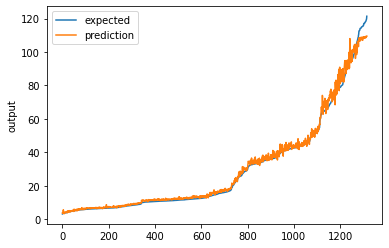

In [ ]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"CNN - Adam-Tanh", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### **Case 4 : SGD - ReLU**

In [ ]:
layers={'Conv': [32, 64 , 128] ,'Dense': 128}
activation=["ReLu"]
optimizer=["sgd"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': [32, 64, 128], 'Dense': 128}, 'activation': ['ReLu'], 'optimizer': ['sgd']}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_OptAct_v4.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
custom_sgd = optimizers.SGD(lr=0.01 , clipvalue=1)

startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding="valid",activation='relu', input_shape=input_shape)) 
  
  model.add(Conv2D(128, (2, 2), padding="valid",activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  # output layer
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer=custom_sgd)
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=2, epochs=1000, batch_size=128)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 1/1000
24/24 - 3s - loss: 832.0941 - val_loss: 763.7186
Epoch 2/1000
24/24 - 3s - loss: 673.9844 - val_loss: 695.8163
Epoch 3/1000
24/24 - 3s - loss: 625.4350 - val_loss: 639.1581
Epoch 4/1000
24/24 - 3s - loss: 504.8280 - val_loss: 592.5878
Epoch 5/1000
24/24 - 3s - loss: 502.8963 - val_loss: 537.5580
Epoch 6/1000
24/24 - 3s - loss: 487.4401 - val_loss: 558.1427
Epoch 7/1000
24/24 - 3s - loss: 455.1275 - val_loss: 515.8284
Epoch 8/1000
24/24 - 3s - loss: 484.4711 - val_loss: 524.0845
Epoch 9/1000
24/24 - 3s - loss: 439.6902 - val_loss: 513.0150
Epoch 10/1000
24/24 - 3s - loss: 433.9864 - val_loss: 484.8567
Epoch 11/1000
24/24 - 3s - loss: 419.5884 - val_loss: 469.0788
Epoch 12/1000
24/24 - 3s - loss: 443.1004 - val_loss: 470.3577
Epoch 13/1000
24/24 - 3s - loss: 391.9906 - val_loss: 423.4165
Epoch 14/1000
24/24 - 3s - loss: 404.3231 - val_loss: 410.4337
Epoch 15/1000
24/24 - 3s - loss: 381.5620 - val_loss: 462.4004
Epoch 16/1000
24/24 - 3s - loss: 366.23

###### Case 4: Model Performance Evaluation

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 5, 3, 512)         5120      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 2, 128)         262272    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 1, 128)         0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 2, 1, 128)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)              

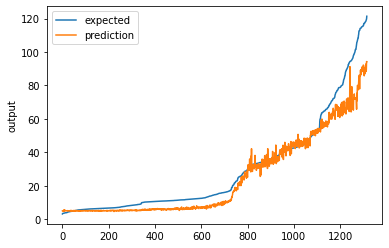

In [ ]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"CNN - SGD-ReLU", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### **Case 5 : SGD - Sigmoid**

In [ ]:
layers={'Conv': [32, 64 , 128] ,'Dense': 128}
activation=["sigmoid"]
optimizer=["sgd"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': [32, 64, 128], 'Dense': 128}, 'activation': ['sigmoid'], 'optimizer': ['sgd']}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_OptAct_v5.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")
custom_sgd = optimizers.SGD(lr=0.01 , clipvalue=0.5)
for i in range(3):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid",activation='sigmoid', input_shape=input_shape)) 
  
  model.add(Conv2D(64, (2, 2), padding="valid",activation='sigmoid'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (2, 2), padding="same",activation='sigmoid'))
  model.add(Dropout(0.20))

  model.add(Flatten())
  model.add(Dense(128, activation='sigmoid'))
  model.add(Dropout(0.5))
  # output layer
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer=custom_sgd)
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 00011: early stopping
Epoch 00021: early stopping
Epoch 00012: early stopping
Elapsed time: 18.683516025543213
Best Model loaded ....


###### Case 5: Model Performance Evaluation

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 5, 3, 32)          320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 1, 64)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 2, 1, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 2, 1, 128)         32896     
_________________________________________________________________
dropout_13 (Dropout)         (None, 2, 1, 128)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)              

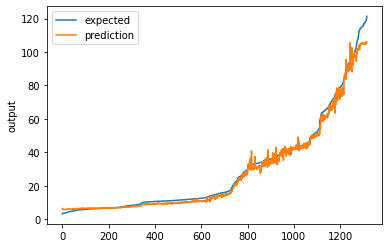

In [ ]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"CNN - SGD-Sigmoid", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### **Case 6 : SGD - Tanh**

In [ ]:
layers={'Conv': [32, 64 , 128] ,'Dense': 128}
activation=["tanh"]
optimizer=["sgd"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': [32, 64, 128], 'Dense': 128}, 'activation': ['tanh'], 'optimizer': ['sgd']}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_OptAct_v6.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid",activation='tanh', input_shape=input_shape)) 
  
  model.add(Conv2D(64, (2, 2), padding="valid",activation='tanh'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, (2, 2), padding="same",activation='tanh'))
  model.add(Dropout(0.20))

  model.add(Flatten())
  model.add(Dense(128, activation='tanh'))
  model.add(Dropout(0.5))
  # output layer
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mse'])
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 00012: early stopping
Epoch 00004: early stopping
Epoch 00009: early stopping
Elapsed time: 11.508138656616211
Best Model loaded ....


###### Case 6: Model Performance Evaluation

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_153 (Conv2D)          (None, 5, 3, 32)          320       
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 4, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 2, 1, 64)          0         
_________________________________________________________________
dropout_162 (Dropout)        (None, 2, 1, 64)          0         
_________________________________________________________________
conv2d_155 (Conv2D)          (None, 2, 1, 128)         32896     
_________________________________________________________________
dropout_163 (Dropout)        (None, 2, 1, 128)         0         
_________________________________________________________________
flatten_74 (Flatten)         (None, 256)             

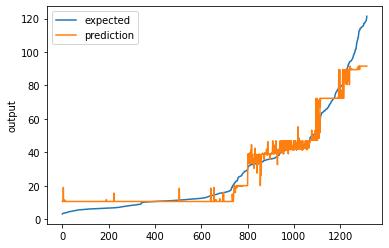

In [ ]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"CNN - SGD-Tanh", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

#### **KERNEL NUMBER AND SIZE**

##### **Case 1 : Kernel number - 128**

In [ ]:
layers={'Conv': 128 ,'Dense': 128}
kernelSize = (2,2)
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'kernel size': kernelSize, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': 64, 'Dense': 128}, 'kernel size': (2, 2), 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_kernel_v1.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(128, kernel_size=(2, 2), padding='valid',input_shape = input_shape, activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.2))

  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 00009: early stopping
Epoch 00017: early stopping
Epoch 00013: early stopping
Elapsed time: 19.146251678466797
Best Model loaded ....


###### Case 1: Model Performance Evaluation

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 6, 4, 128)         640       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 3, 2, 128)         0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 3, 2, 128)         0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 768)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 128)               98432     
_________________________________________________________________
dropout_62 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)               

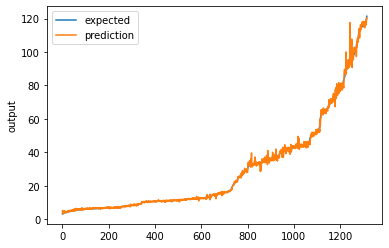

In [ ]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"Kernel Count - 128", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### **Case 2 : Kernel number - 256**

In [ ]:
layers={'Conv': 256 ,'Dense': 128}
kernelSize = (2,2)
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'kernel size': kernelSize, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': 256, 'Dense': 128}, 'kernel size': (2, 2), 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_kernel_v2.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(256, kernel_size=(2, 2), padding='valid',input_shape = input_shape, activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.2))

  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 00014: early stopping
Epoch 00010: early stopping
Epoch 00010: early stopping
Elapsed time: 24.726283073425293
Best Model loaded ....


###### Case 2: Model Performance Evaluation

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 6, 4, 256)         1280      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 3, 2, 256)         0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 3, 2, 256)         0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 1536)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 128)               196736    
_________________________________________________________________
dropout_68 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)               

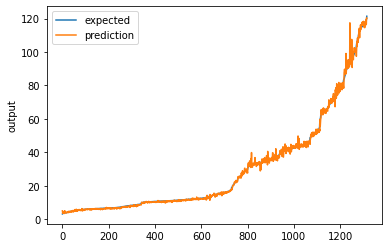

In [ ]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"Kernel Count - 256", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### **Case 3 : Kernel number - 512**

In [ ]:
layers={'Conv': 512 ,'Dense': 128}
kernelSize = (2,2)
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'kernel size': kernelSize, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': 512, 'Dense': 128}, 'kernel size': (2, 2), 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_kernel_v3.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(512, kernel_size=(2, 2), padding='valid',input_shape = input_shape, activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.2))

  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 00007: early stopping
Epoch 00007: early stopping
Epoch 00010: early stopping
Elapsed time: 28.444684982299805
Best Model loaded ....


###### Case 3: Model Performance Evaluation

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 6, 4, 512)         2560      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 3, 2, 512)         0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 3, 2, 512)         0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 128)               393344    
_________________________________________________________________
dropout_74 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)               

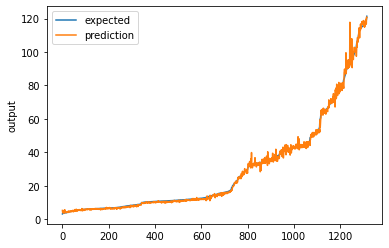

In [ ]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"Kernel Count - 512", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### **Case 4 : Kernel Size - (3,3)**

In [ ]:
layers={'Conv': 512 ,'Dense': 128}
kernelSize = (3,3)
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'kernel size': kernelSize, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': 512, 'Dense': 128}, 'kernel size': (3, 3), 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_kernel_v4.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(512, kernel_size=(3, 3), padding='valid',input_shape = input_shape, activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.2))

  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 00008: early stopping
Epoch 00006: early stopping
Epoch 00006: early stopping
Elapsed time: 14.742343425750732
Best Model loaded ....


###### Case 4: Model Performance Evaluation

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 5, 3, 512)         5120      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 2, 1, 512)         0         
_________________________________________________________________
dropout_79 (Dropout)         (None, 2, 1, 512)         0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_64 (Dense)             (None, 128)               131200    
_________________________________________________________________
dropout_80 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 1)               

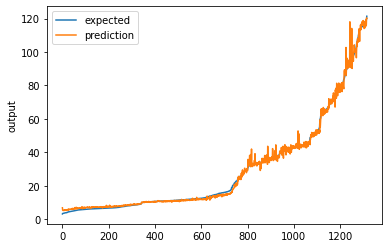

In [ ]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"Kernel Size - (3,3)", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### **Case 5 : Kernel Size - (6,6)**

In [ ]:
layers={'Conv': 512 ,'Dense': 128}
kernelSize = (6,6)
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'kernel size': kernelSize, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': 512, 'Dense': 128}, 'kernel size': (6, 6), 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_kernel_v5.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(240, kernel_size=(6, 6), padding='same',input_shape = input_shape, activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.2))

  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 00007: early stopping
Epoch 00014: early stopping
Epoch 00013: early stopping
Elapsed time: 30.616490125656128
Best Model loaded ....


###### Case 5: Model Performance Evaluation

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 7, 5, 240)         8880      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 3, 2, 240)         0         
_________________________________________________________________
dropout_85 (Dropout)         (None, 3, 2, 240)         0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 1440)              0         
_________________________________________________________________
dense_70 (Dense)             (None, 128)               184448    
_________________________________________________________________
dropout_86 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 1)               

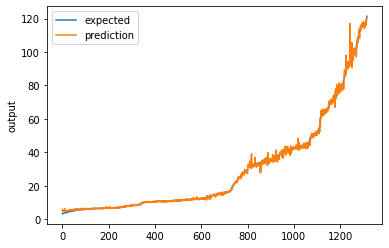

In [ ]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"Kernel Size - (6,6)", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### **Case 6 : Kernel Size - (8,8)**

In [ ]:
layers={'Conv': 512 ,'Dense': 128}
kernelSize = (8,8)
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'kernel size': kernelSize, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'Conv': 512, 'Dense': 128}, 'kernel size': (8, 8), 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import time

input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3]) # shape of one record/instance

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_CNN_kernel_v6.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()

print("Model training begins...")

for i in range(3):
  model = Sequential()
  model.add(Conv2D(512, kernel_size=(8,8), padding='same',input_shape = input_shape, activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.10))

  model.add(Flatten())
  model.add(Dense(128, activation="relu"))
  model.add(Dropout(0.2))

  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
  # Early Stopping to prevent overfitting
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode="auto")
  model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks= [monitor, checkpoint], verbose=0, epochs=500)

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

print("Best Model loaded ....")
model.load_weights(filepath_savemodel)

Model training begins...
Epoch 00009: early stopping
Epoch 00005: early stopping
Epoch 00011: early stopping
Elapsed time: 40.788877964019775
Best Model loaded ....


###### Case 6: Model Performance Evaluation

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 7, 5, 512)         33280     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 3, 2, 512)         0         
_________________________________________________________________
dropout_91 (Dropout)         (None, 3, 2, 512)         0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_76 (Dense)             (None, 128)               393344    
_________________________________________________________________
dropout_92 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 1)               

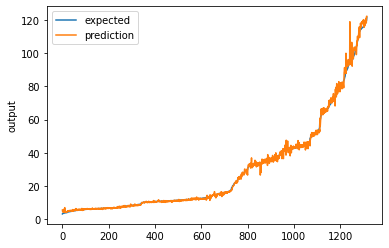

In [ ]:
# Model layer Summary
model.summary()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"Kernel Size - (8,8)", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)